In [34]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install scipy


In [35]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from natsort import natsorted
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import shap
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.transform import Rotation as R

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [36]:
data_train_file_1   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_1.csv')
data_train_file_4   = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_4.csv')

data_test_file_2    = pd.read_csv('/content/drive/My Drive/OpenPack dataset S1/Data/Gen_data/File_2.csv')



In [37]:
# a()

In [38]:
data_train = pd.concat([data_train_file_1, data_train_file_4], ignore_index=True)

In [39]:
data_train = data_train.drop(['Unnamed: 0', 'action'], axis = 1)
data_train['operation'] = data_train['operation'].astype('category')

data_test_file_2 = data_test_file_2.drop(['Unnamed: 0', 'action'], axis = 1)
data_test_file_2['operation'] = data_test_file_2['operation'].astype('category')



In [40]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148433 entries, 0 to 148432
Data columns (total 41 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   atr01/acc_x   148433 non-null  float64 
 1   atr01/acc_y   148433 non-null  float64 
 2   atr01/acc_z   148433 non-null  float64 
 3   atr01/gyro_x  148433 non-null  float64 
 4   atr01/gyro_y  148433 non-null  float64 
 5   atr01/gyro_z  148433 non-null  float64 
 6   atr01/quat_w  148433 non-null  float64 
 7   atr01/quat_x  148433 non-null  float64 
 8   atr01/quat_y  148433 non-null  float64 
 9   atr01/quat_z  148433 non-null  float64 
 10  atr02/acc_x   148433 non-null  float64 
 11  atr02/acc_y   148433 non-null  float64 
 12  atr02/acc_z   148433 non-null  float64 
 13  atr02/gyro_x  148433 non-null  float64 
 14  atr02/gyro_y  148433 non-null  float64 
 15  atr02/gyro_z  148433 non-null  float64 
 16  atr02/quat_w  148433 non-null  float64 
 17  atr02/quat_x  148433 non-null

In [41]:
def feature_extraction(data):
  for i in range(1, 5):
    # Độ lớn.
    acc_x, acc_y, acc_z = f'atr0{i}/acc_x', f'atr0{i}/acc_y', f'atr0{i}/acc_z'
    gyro_x, gyro_y, gyro_z = f'atr0{i}/gyro_x', f'atr0{i}/gyro_y', f'atr0{i}/gyro_z'
    quat_w, quat_x, quat_y, quat_z = f'atr0{i}/quat_w', f'atr0{i}/quat_x', f'atr0{i}/quat_y', f'atr0{i}/quat_z'

    data[f'atr0{i}/acc_mag']  = np.sqrt(data[acc_x]**2  + data[acc_y]**2  + data[acc_z]**2)
    data[f'atr0{i}/gyro_mag'] = np.sqrt(data[gyro_x]**2 + data[gyro_y]**2 + data[gyro_z]**2)
    data[f'atr0{i}/quat_mag'] = np.sqrt(data[quat_w]**2 + data[quat_x]**2 + data[quat_y]**2 + data[quat_z]**2)

    # Góc quay
    valid = (data[acc_z] != 0) & (data[acc_x] != 0) & (data[acc_y] != 0)
    data[f'atr0{i}/tilt_angle_x'] = np.where(
        valid,
        np.degrees(np.arctan2(data[acc_y], data[acc_z])),
        0
    )
    data[f'atr0{i}/tilt_angle_y'] = np.where(
        valid,
        np.degrees(np.arctan2(data[acc_x], np.sqrt(data[acc_y]**2 + data[acc_z]**2))),
        0
    )

  # Diff cho acc (3 trục + magnitude)
  for i in range(1, 5):
    acc_x, acc_y, acc_z = f'atr0{i}/acc_x', f'atr0{i}/acc_y', f'atr0{i}/acc_z'
    mag = f'atr0{i}/acc_mag'

    data[f'atr0{i}/acc_x_diff']   = data[acc_x].diff().fillna(0)
    data[f'atr0{i}/acc_y_diff']   = data[acc_y].diff().fillna(0)
    data[f'atr0{i}/acc_z_diff']   = data[acc_z].diff().fillna(0)
    data[f'atr0{i}/acc_mag_diff'] = data[mag].diff().fillna(0)

  # Diff cho gyro (3 trục + magnitude)
  for i in range(1, 5):
    gyro_x, gyro_y, gyro_z = f'atr0{i}/gyro_x', f'atr0{i}/gyro_y', f'atr0{i}/gyro_z'
    mag = f'atr0{i}/gyro_mag'

    data[f'atr0{i}/gyro_x_diff']   = data[gyro_x].diff().fillna(0)
    data[f'atr0{i}/gyro_y_diff']   = data[gyro_y].diff().fillna(0)
    data[f'atr0{i}/gyro_z_diff']   = data[gyro_z].diff().fillna(0)
    data[f'atr0{i}/gyro_mag_diff'] = data[mag].diff().fillna(0)

  # Hiệu độ lớn giữa cặp cảm biến
  data['acc_mag_diff_01_02'] = data['atr01/acc_mag'] - data['atr02/acc_mag']
  data['acc_mag_diff_03_04'] = data['atr03/acc_mag'] - data['atr04/acc_mag']

  return data


In [42]:
data_train          = feature_extraction(data_train)
data_test_file_2    = feature_extraction(data_test_file_2)

In [43]:
data_train.columns

Index(['atr01/acc_x', 'atr01/acc_y', 'atr01/acc_z', 'atr01/gyro_x',
       'atr01/gyro_y', 'atr01/gyro_z', 'atr01/quat_w', 'atr01/quat_x',
       'atr01/quat_y', 'atr01/quat_z', 'atr02/acc_x', 'atr02/acc_y',
       'atr02/acc_z', 'atr02/gyro_x', 'atr02/gyro_y', 'atr02/gyro_z',
       'atr02/quat_w', 'atr02/quat_x', 'atr02/quat_y', 'atr02/quat_z',
       'atr03/acc_x', 'atr03/acc_y', 'atr03/acc_z', 'atr03/gyro_x',
       'atr03/gyro_y', 'atr03/gyro_z', 'atr03/quat_w', 'atr03/quat_x',
       'atr03/quat_y', 'atr03/quat_z', 'atr04/acc_x', 'atr04/acc_y',
       'atr04/acc_z', 'atr04/gyro_x', 'atr04/gyro_y', 'atr04/gyro_z',
       'atr04/quat_w', 'atr04/quat_x', 'atr04/quat_y', 'atr04/quat_z',
       'operation', 'atr01/acc_mag', 'atr01/gyro_mag', 'atr01/quat_mag',
       'atr01/tilt_angle_x', 'atr01/tilt_angle_y', 'atr02/acc_mag',
       'atr02/gyro_mag', 'atr02/quat_mag', 'atr02/tilt_angle_x',
       'atr02/tilt_angle_y', 'atr03/acc_mag', 'atr03/gyro_mag',
       'atr03/quat_mag', 'atr03/

In [44]:
data_test_file_2.columns

Index(['atr01/acc_x', 'atr01/acc_y', 'atr01/acc_z', 'atr01/gyro_x',
       'atr01/gyro_y', 'atr01/gyro_z', 'atr01/quat_w', 'atr01/quat_x',
       'atr01/quat_y', 'atr01/quat_z', 'atr02/acc_x', 'atr02/acc_y',
       'atr02/acc_z', 'atr02/gyro_x', 'atr02/gyro_y', 'atr02/gyro_z',
       'atr02/quat_w', 'atr02/quat_x', 'atr02/quat_y', 'atr02/quat_z',
       'atr03/acc_x', 'atr03/acc_y', 'atr03/acc_z', 'atr03/gyro_x',
       'atr03/gyro_y', 'atr03/gyro_z', 'atr03/quat_w', 'atr03/quat_x',
       'atr03/quat_y', 'atr03/quat_z', 'atr04/acc_x', 'atr04/acc_y',
       'atr04/acc_z', 'atr04/gyro_x', 'atr04/gyro_y', 'atr04/gyro_z',
       'atr04/quat_w', 'atr04/quat_x', 'atr04/quat_y', 'atr04/quat_z',
       'operation', 'atr01/acc_mag', 'atr01/gyro_mag', 'atr01/quat_mag',
       'atr01/tilt_angle_x', 'atr01/tilt_angle_y', 'atr02/acc_mag',
       'atr02/gyro_mag', 'atr02/quat_mag', 'atr02/tilt_angle_x',
       'atr02/tilt_angle_y', 'atr03/acc_mag', 'atr03/gyro_mag',
       'atr03/quat_mag', 'atr03/

In [45]:

print("Kích thước dữ liệu train:", data_train.shape)
print("Kích thước dữ liệu test:", data_test_file_2.shape)



Kích thước dữ liệu train: (148433, 93)
Kích thước dữ liệu test: (64787, 93)


In [46]:
target = "operation"

X_train = data_train.drop(target, axis=1)
y_train = data_train[target]

X_test = data_test_file_2.drop(target, axis=1)
y_test = data_test_file_2[target]

In [47]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Trước SMOTE:", pd.Series(y_train_encoded).value_counts())
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("Sau SMOTE:", pd.Series(y_train_resampled).value_counts())

print("Nhãn trong y_train_resampled:", np.unique(y_train_resampled))
print("Nhãn trong y_test_encoded:", np.unique(y_test_encoded))


Trước SMOTE: 2     22720
0     20842
1     20038
6     17815
3     17735
4     12759
7      9567
9      9052
5      6181
10     6008
8      5716
Name: count, dtype: int64
Sau SMOTE: 0     22720
1     22720
2     22720
10    22720
3     22720
4     22720
5     22720
6     22720
7     22720
8     22720
9     22720
Name: count, dtype: int64
Nhãn trong y_train_resampled: [ 0  1  2  3  4  5  6  7  8  9 10]
Nhãn trong y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10]



🔍 Đang huấn luyện mô hình: Random Forest
AUROC của Random Forest: 0.8357
              precision    recall  f1-score   support

         100       0.32      0.70      0.44      6526
         200       0.58      0.35      0.44     10660
         300       0.50      0.49      0.50      9221
         400       0.46      0.62      0.53      6429
         500       0.44      0.22      0.29      4943
         600       0.38      0.44      0.41      2585
         700       0.68      0.71      0.70     10140
         800       0.54      0.39      0.45      4466
         900       0.39      0.56      0.46      3776
        1000       0.64      0.08      0.15      4872
        8100       0.08      0.07      0.08      1169

    accuracy                           0.47     64787
   macro avg       0.45      0.42      0.40     64787
weighted avg       0.51      0.47      0.46     64787



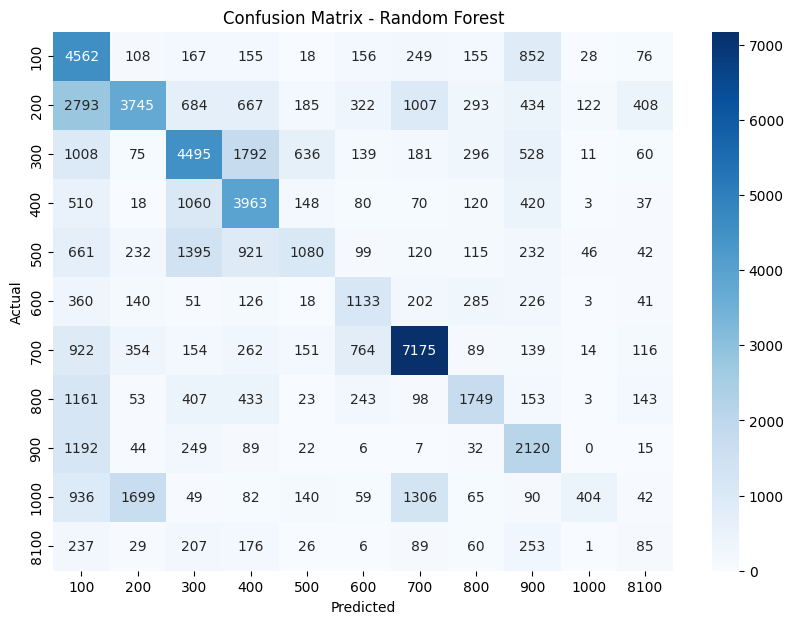


🔍 Đang huấn luyện mô hình: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUROC của Logistic Regression: 0.8195
              precision    recall  f1-score   support

         100       0.27      0.29      0.28      6526
         200       0.61      0.12      0.20     10660
         300       0.42      0.37      0.39      9221
         400       0.52      0.39      0.44      6429
         500       0.33      0.20      0.25      4943
         600       0.24      0.48      0.32      2585
         700       0.76      0.82      0.79     10140
         800       0.35      0.47      0.40      4466
         900       0.28      0.76      0.41      3776
        1000       0.38      0.21      0.27      4872
        8100       0.02      0.08      0.03      1169

    accuracy                           0.40     64787
   macro avg       0.38      0.38      0.34     64787
weighted avg       0.46      0.40      0.39     64787



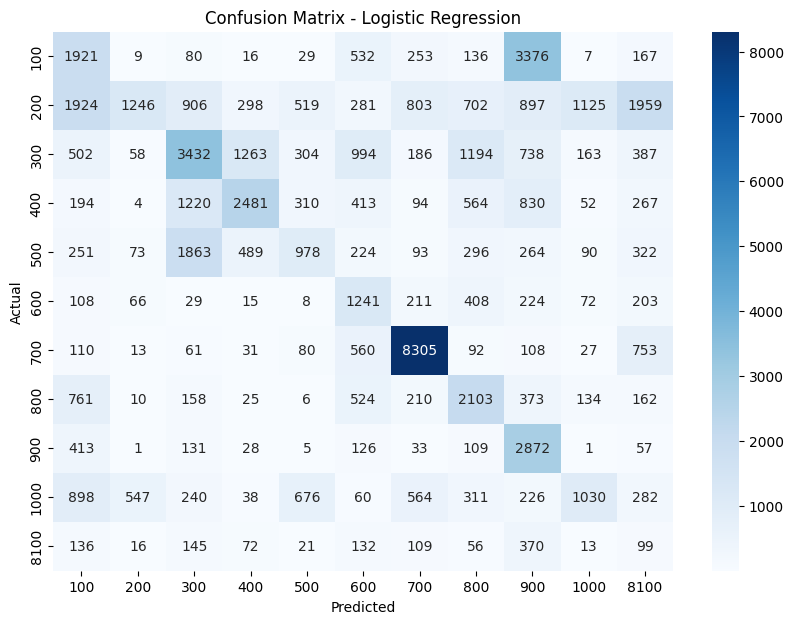


🔍 Đang huấn luyện mô hình: KNN (K-Nearest Neighbors)
AUROC của KNN (K-Nearest Neighbors): 0.6977
              precision    recall  f1-score   support

         100       0.33      0.48      0.39      6526
         200       0.38      0.31      0.34     10660
         300       0.37      0.14      0.21      9221
         400       0.49      0.25      0.33      6429
         500       0.20      0.18      0.19      4943
         600       0.12      0.21      0.15      2585
         700       0.61      0.56      0.58     10140
         800       0.33      0.41      0.36      4466
         900       0.33      0.31      0.32      3776
        1000       0.34      0.48      0.40      4872
        8100       0.02      0.12      0.04      1169

    accuracy                           0.34     64787
   macro avg       0.32      0.31      0.30     64787
weighted avg       0.38      0.34      0.34     64787



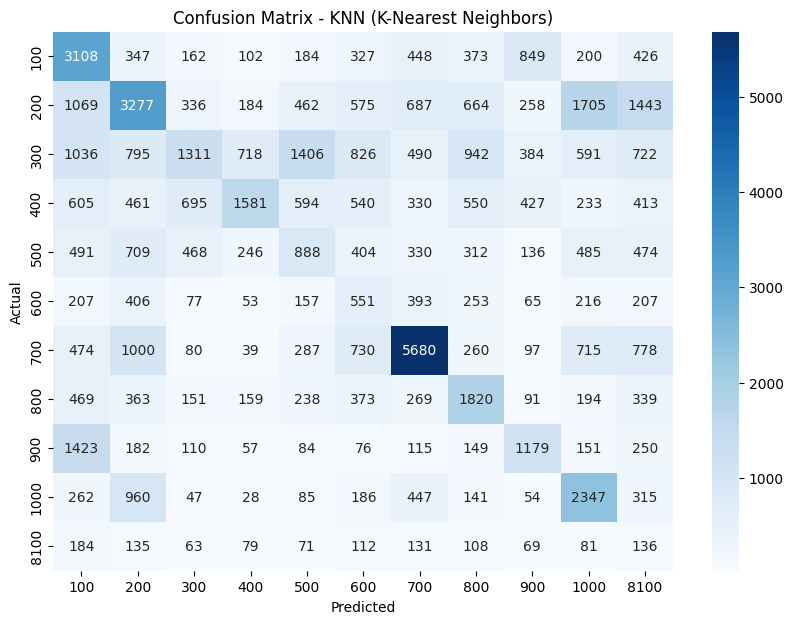


🔍 Đang huấn luyện mô hình: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:16:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:16:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


AUROC của XGBoost: 0.8726
              precision    recall  f1-score   support

         100       0.39      0.69      0.50      6526
         200       0.62      0.27      0.38     10660
         300       0.54      0.53      0.54      9221
         400       0.52      0.63      0.57      6429
         500       0.54      0.22      0.31      4943
         600       0.40      0.55      0.46      2585
         700       0.67      0.81      0.73     10140
         800       0.48      0.55      0.52      4466
         900       0.44      0.60      0.51      3776
        1000       0.67      0.19      0.29      4872
        8100       0.04      0.07      0.05      1169

    accuracy                           0.51     64787
   macro avg       0.48      0.46      0.44     64787
weighted avg       0.54      0.51      0.49     64787



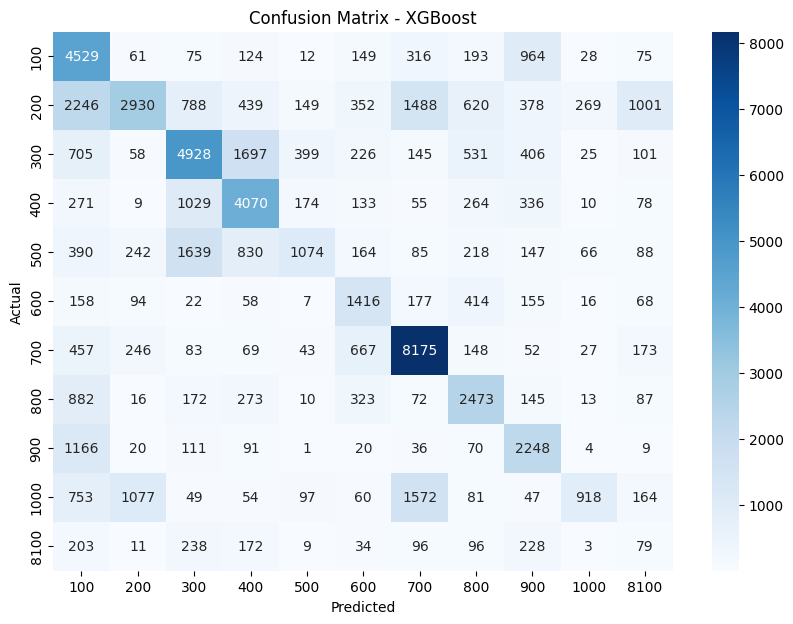


🔍 Đang huấn luyện mô hình: LightGBM
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 23320
[LightGBM] [Info] Number of data points in the train set: 249920, number of used features: 92


LightGBMError: No OpenCL device found

In [48]:
# Các model sẽ thử nghiệm
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier
     (
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        tree_method='hist',  # Sử dụng phương pháp 'hist' kết hợp với GPU
        device='cuda'        # Chỉ định sử dụng GPU
    ),
    "LightGBM": LGBMClassifier
     (
        n_estimators=200,
        learning_rate=0.1
      )
}

# Huấn luyện và đánh giá từng model
for model_name, model in models.items():
    print(f"\n🔍 Đang huấn luyện mô hình: {model_name}")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_encoded = model.predict(X_test)

    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        if len(np.unique(y_test_encoded)) == 2:
            auc = roc_auc_score(y_test_encoded, y_pred_proba[:, 1], average='macro')
        else:
            auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')
        print(f"AUROC của {model_name}: {auc:.4f}")
    else:
        print(f"{model_name} không hỗ trợ predict_proba().")

    print(classification_report(y_test_original, y_pred))

    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test_original, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()